# Cycling traffic in the City of Copenhagen 🚲

# 1. Problem definition

Copenhagen is well-known for it's well-established cycling infrastructure, with around 400 kilometers of cyclepaths threading through the city. According to the [2022 Copenhagen Bicycle Account](https://kk.sites.itera.dk/apps/kk_pub2/index.asp?mode=detalje&id=2420), around 62% of the citizens of Copenhagen cycle several times a week. There are around 745,800 bicycles in the Danish capital, which is more than five times the number of cars in Copenhagen.

This project aims to uncover patterns in hourly bicycle traffic by analyzing historical traffic data. Our goal is to understand how cycling traffic fluctuates throughout the day at various locations in the city and how factors such as weather conditions and public holidays impact the number of cyclists on Copenhagen's roads. Ultimately, we aim to develop a machine learning model capable of predicting bicycle traffic for any given hour using weather forecasts and other publicly available data.

# 2. Data

Bicycle traffic is counted hourly at several counting stations accross the city. Data between 2005 and 2014 is publicly available at [opendata.dk](https://www.opendata.dk/city-of-copenhagen/faste-trafiktaellinger). Below is the dataset description:

> Here you can find figures for traffic from Copenhagen’s fixed counting points. Road ID tells where the counting station is located. - and + after road-Id describe the direction where counting is done. T stands for total traffic. The road name tells which road the counting station is on. The road name corresponds to the Road ID. The UTM X and Y coordinates can be used to identify the exact position of the counting station. The day on which the counts have been carried out can be found under Date and the remaining columns are divided by the hour counted.
This data is historical and is no longer maintained.

The dataset is also available on [Kaggle](https://www.kaggle.com/datasets/emilhvitfeldt/bike-traffic-counts-in-copenhagen), where separate original yearly files are concatenated into a single file. The analysis will be carried out on this version of the dataset.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from astral.location import LocationInfo
from astral.sun import sun
import holidays
from meteostat import Point, Stations, Daily
import requests
import utm
import os
import json
from PIL import Image
from time import sleep
import geopandas as gpd
from shapely.geometry import Point

In [2]:
# Read dataset
traffic_data = pd.read_csv("data/total_rides.csv")

In [3]:
traffic_data.head(4)

,road_name,date,time,n
0,Englandsvej,2005-01-01,00-01,5.0
1,Englandsvej,2005-01-01,01-02,13.0
2,Englandsvej,2005-01-01,02-03,10.0
3,Englandsvej,2005-01-01,03-04,23.0


In [4]:
# Parse date and time in one datetime variable, and infer temporal variables from the datetime object

# Parse datetime
traffic_data['datetime'] = pd.to_datetime(traffic_data.date + ' ' + traffic_data.time.str.slice(stop=2))
traffic_data['date'] = pd.to_datetime(traffic_data.date)

# Get rid of old time variable
traffic_data.drop("time", axis = 1, inplace=True)

# Create year, month, dayOfTheWeek variables
traffic_data["year"] = traffic_data.datetime.dt.year
traffic_data["month"] = traffic_data.datetime.dt.month
traffic_data["hour"] = traffic_data.datetime.dt.hour
traffic_data["day_of_week"] = traffic_data.datetime.dt.day_of_week

In [5]:
traffic_data.head(4)

,road_name,date,n,datetime,year,month,hour,day_of_week
0,Englandsvej,2005-01-01,5.0,2005-01-01 00:00:00,2005,1,0,5
1,Englandsvej,2005-01-01,13.0,2005-01-01 01:00:00,2005,1,1,5
2,Englandsvej,2005-01-01,10.0,2005-01-01 02:00:00,2005,1,2,5
3,Englandsvej,2005-01-01,23.0,2005-01-01 03:00:00,2005,1,3,5


In [6]:
# create a function to calculate dawn and dusk times for copenhagen using astral
def get_dusk_dawn(date, loc = LocationInfo(name='CPH', latitude=55.676098, longitude=12.568337)):
    # get the sun times for the location and date
    # (returns a dict with the time of several sun-related events (such as dawn, dusk, noon, etc)
    s = sun(loc.observer, date=date, tzinfo=loc.timezone)
    
    # create dawn-dusk tuple and return it (while removing time zone info for easier handling)
    return((s["dawn"].replace(tzinfo=None), s["dusk"].replace(tzinfo=None)))


In [7]:
# we calculate dawn and dusk times only for unique days, not for the whole dataset
unique_dates = pd.DataFrame({"date":traffic_data.date.unique()})
unique_dates[['dawn', 'dusk']] = unique_dates.date.apply(lambda x: pd.Series(get_dusk_dawn(x)))

In [8]:
unique_dates.head(4)

,date,dawn,dusk
0,2005-01-01,2005-01-01 06:52:09.615377,2005-01-01 15:34:48.488185
1,2005-01-02,2005-01-02 06:51:59.734554,2005-01-02 15:35:55.559258
2,2005-01-03,2005-01-03 06:51:46.317821,2005-01-03 15:37:05.456250
3,2005-01-04,2005-01-04 06:51:29.380296,2005-01-04 15:38:18.104864


In [9]:
# merging with original dataset
traffic_data = pd.merge(traffic_data, unique_dates, on = "date")

In [10]:
# calculate time difference from dawn and dusk
traffic_data["dawn_diff"] = traffic_data.datetime-traffic_data.dawn
traffic_data["dusk_diff"] = traffic_data.dusk - traffic_data.datetime

# determine daytime variable based on time differences
# daytime == 1 >> daylight
# daytime == 0 >> nighttime
traffic_data['daytime'] = np.where((traffic_data['dawn_diff'] > datetime.timedelta(0)) &
                                   (traffic_data['dusk_diff'] > datetime.timedelta(0)), 1, 0)

# also let's save the ratio of daytime to a variable (ie. cca 0.8 in july means that there's daylight approximately 80% of the day
# maybe this could be used when illustrating information that changes across months
traffic_data['daytime_ratio'] = (traffic_data.dusk-traffic_data.dawn)/datetime.timedelta(days = 1)
traffic_data.drop(["dawn", "dusk", "dawn_diff", "dusk_diff"], axis = 1, inplace=True)

## 2.2. Holiday Data
A variable we could easily infer from the existing datetime column is if a day is a national holiday in Denmark - a factor that, according to intuition, will surely influence traffic on that day.
We add national holiday variable (1: day is holiday, 0: not holiday) using the `holidays` library.

In [11]:
danish_holidays = holidays.DK()

traffic_data["is_holiday"] = [1 if d in danish_holidays else 0 for d in traffic_data.date]

## 2.3. Weather data

Weather is a factor that is likely to influence cycling traffic. Our aim is to get publicly availablke weather data, specifically temperature, wind speed and precipiation.

Fetch weather data using `meteostat` library.

In [12]:
# Define the location for Copenhagen (latitude, longitude)
location = Point(55.676098, 12.568337)
stations = Stations()

# Get nearby weather stations
stations = stations.nearby(55.676098, 12.568337)
station = stations.fetch(3)
print(station)

                                name country region    wmo  icao  latitude  \
id                                                                           
06186  Koebenhavn / Landbohoejskolen      DK     HS  06186  <NA>   55.6833   
06180           Koebenhavn / Kastrup      DK     HS  06180  EKCH   55.6167   
06160                      Vaerloese      DK     HS  06160  EKVL   55.7667   

       longitude  elevation           timezone hourly_start hourly_end  \
id                                                                       
06186    12.5333        9.0  Europe/Copenhagen          NaT        NaT   
06180    12.6500        5.0  Europe/Copenhagen   1929-08-01 2024-08-04   
06160    12.3333       18.0  Europe/Copenhagen   1939-11-01 2007-02-27   

      daily_start  daily_end monthly_start monthly_end      distance  
id                                                                    
06186  1873-12-31 2019-12-31    1874-01-01  2021-01-01   2338.029565  
06180  1973-01-18 2022-04

We'll use the weather station with ID "06180" as this produces the dataset that contains the least missing values.
Note that the station is a bit away from the city center, but that cca. 6km distance probably will not make a big difference when it comes to weather data.

In [13]:
# Define the time period for the data
start = np.min(traffic_data.datetime)
end = np.max(traffic_data.datetime)

# Fetch daily weather data
weather_data = Daily("06180", start, end)
weather_data = weather_data.fetch()

# Convert to Pandas DataFrame
weather_df = pd.DataFrame(weather_data).rename_axis('date').reset_index()

In [77]:
# write meteostat weather data to csv
weather_df.to_csv("data/weather_meteostat.csv", index=False)

In [14]:
weather_df.head(3)

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2005-01-01,2.2,-1.0,4.0,NaN,NaN,239.0,17.7,NaN,NaN,NaN
1,2005-01-02,3.2,1.3,5.6,NaN,NaN,248.0,36.5,NaN,999.5,NaN
2,2005-01-03,3.5,1.9,6.4,NaN,NaN,273.0,33.8,NaN,1009.8,NaN


 >  **There's a lot of missing data, especially the lack of precipiation data is alarming since rainfall is expected to be a factor influencing cycling traffic.**

> To fill this gap, we also obtain weather data from a second source. We'll use the API of the **National Oceanic and Atmospheric Administration** (NOAA), to create an alternative dataset.

In [79]:
# Load API key from credentials.json file
credentials = {}
try:
    with open('credentials.json') as file:
        credentials = json.load(file)
except FileNotFoundError:
    print("Error: credentials.json file not found.")

# NOAA API endpoint and token
BASE_URL = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'
API_TOKEN = credentials.get('weatherAPIkey', 'YOUR_API_TOKEN_HERE')

# Function to fetch data from NOAA API
def fetch_noaa_data(start_date, end_date, location_id, dataset='GHCND', data_types=['PRCP', 'TMIN', 'TMAX']):
    headers = {'token': API_TOKEN}
    params = {
        'datasetid': dataset,
        'locationid': location_id,
        'startdate': start_date,
        'enddate': end_date,
        'datatypeid': data_types,
        'limit': 1000,
        'units': 'metric'
    }
    
    response = requests.get(BASE_URL, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Request failed with status code {response.status_code}: {response.text}")


# Function to convert JSON data to pandas DataFrame
def json_to_dataframe(json_data):
    records = json_data.get('results', [])
    df = pd.DataFrame(records)
    if not df.empty:
        df['date'] = pd.to_datetime(df['date'])
    return df

# Fetch data for Copenhagen between 2005 and 2014
location_id = 'CITY:DA000001'  # NOAA location ID for Copenhagen

# Create an empty DataFrame to store the results
weather_noaa = pd.DataFrame()

# Loop over each year to fetch data
for year in range(2005, 2015):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    json_data = fetch_noaa_data(start_date, end_date, location_id)
    yearly_data = json_to_dataframe(json_data)
    weather_noaa = pd.concat([weather_noaa, yearly_data], ignore_index=True)

# Pivot the data to have columns for each data type
if not weather_noaa.empty:
    weather_noaa = weather_noaa.pivot_table(index=['date', 'station'], columns='datatype', values='value', aggfunc='first').reset_index()

In [23]:
# write NOAA weather data to csv
weather_noaa.columns = map(str.lower, weather_noaa.columns)
weather_noaa.to_csv("data/weather_noaa.csv", index = False)

In [15]:
# read NOAA data
weather_noaa = pd.read_csv("data/weather_noaa.csv", parse_dates=["date"])
weather_noaa.head()

,date,station,prcp,tmax,tmin
0,2005-01-01,GHCND:DAM00006030,0.5,NaN,0.3
1,2005-01-02,GHCND:DAM00006030,2.8,6.1,1.4
2,2005-01-03,GHCND:DAM00006030,0.3,NaN,1.9
3,2005-01-04,GHCND:DAM00006030,3.0,8.2,4.9
4,2005-01-05,GHCND:DAM00006030,0.0,6.9,NaN


> Merge the two weather datasets.

In [16]:
# Merge the two weather datasets
weather = pd.merge(weather_df, weather_noaa, on = "date")

# For tmin and tmax, we have values from both datasets
# We'll use the mean of the tue values (where one is NaN, the mean is the other value)
weather['tmax'] = weather[['tmax_x', 'tmax_y']].mean(axis=1)
weather['tmin'] = weather[['tmin_x', 'tmin_y']].mean(axis=1)
weather.drop(["prcp_x", "wpgt", "tsun", "station", "tmax_x", "tmax_y", "tmin_x", "tmin_y", "snow"], axis = 1, inplace=True)

In [17]:
# add to traffic dataset
traffic_data = pd.merge(traffic_data, weather, on = "date")
traffic_data.rename(columns={"prcp_y":"prcp"}, inplace = True)

## 2.4. Location data

Our `traffic_data` DataFrame right now only contains the name of the road on wich the traffic was counted. Let's enrich our dataset with the spatial relations of these counting stations. The Kaggle dataset contains the `road_info.csv` file, which has UTM (Universal Transverse Mercator) coordinates for each counting station (13 stations in total).

We'll import this dataset, convert the UTM coordinates to latitudes and longitudes, and calculate how far from the city center each of these stations are.

In [18]:
road_info = pd.read_csv("data/road_info.csv")
# we need to convert utm coordinates to lat-long (in utm zone 32n)

def rule(row):
    lat, lon = utm.to_latlon(row["x_coord"], row["y_coord"], 32, 'N')
    return pd.Series({"lat": lat, "lon": lon})

road_info = road_info.merge(road_info.apply(rule, axis=1), left_index= True, right_index= True)

# Add city center (Rådhuspladsen) coordinates to dataframe
road_info["centre_x"] = 55.675903
road_info["centre_y"] = 12.568995
road_info.head(3)

,road_id,road_name,x_coord,y_coord,lat,lon,centre_x,centre_y
0,101 1011600-0 2/ 400,Englandsvej,726552,6171708,55.638347,12.599838,55.675903,12.568995
1,101 1013332-0 0/ 781,Jagtvej,722980,6177692,55.693664,12.548061,55.675903,12.568995
2,101 1015968-0 1/ 60,Roskildevej,718731,6175142,55.672726,12.478559,55.675903,12.568995


In [19]:
# Function to calculate distance between two points
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [20]:
# Get distance from city center for each counting station
road_info["dist_from_center"] = haversine(road_info.centre_x, road_info.centre_y,
                 road_info.lat, road_info.lon)

road_info.drop(["x_coord", "y_coord", "centre_x", "centre_y", "x_coord", "y_coord", "road_id"], axis = 1, inplace = True)

In [21]:
# Merge location data with main dataset
traffic_data = pd.merge(traffic_data, road_info, on = "road_name")

In [87]:
# Write complete dataset to file
traffic_data.to_csv("data/traffic_data.csv", index = False)
traffic_data.head()

,road_name,date,n,datetime,year,month,hour,day_of_week,daytime,daytime_ratio,...,tavg,wdir,wspd,pres,prcp,tmax,tmin,lat,lon,dist_from_center
0,Englandsvej,2005-01-01,5.0,2005-01-01 00:00:00,2005,1,0,5,0,0.36295,...,2.2,239.0,17.7,NaN,0.5,4.0,-0.35,55.638347,12.599838,4.602445
1,Englandsvej,2005-01-01,13.0,2005-01-01 01:00:00,2005,1,1,5,0,0.36295,...,2.2,239.0,17.7,NaN,0.5,4.0,-0.35,55.638347,12.599838,4.602445
2,Englandsvej,2005-01-01,10.0,2005-01-01 02:00:00,2005,1,2,5,0,0.36295,...,2.2,239.0,17.7,NaN,0.5,4.0,-0.35,55.638347,12.599838,4.602445
3,Englandsvej,2005-01-01,23.0,2005-01-01 03:00:00,2005,1,3,5,0,0.36295,...,2.2,239.0,17.7,NaN,0.5,4.0,-0.35,55.638347,12.599838,4.602445
4,Englandsvej,2005-01-01,15.0,2005-01-01 04:00:00,2005,1,4,5,0,0.36295,...,2.2,239.0,17.7,NaN,0.5,4.0,-0.35,55.638347,12.599838,4.602445


# 3. Exploratory data analysis

In [2]:
# Read in complete dataset
traffic_data = pd.read_csv("data/traffic_data.csv", parse_dates=["date", "datetime"])

First, let's take a look at the distribution of the target variable n (number of cyclists in one hour).

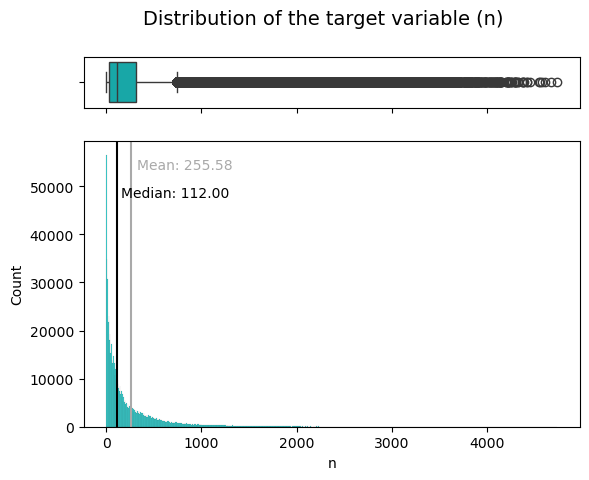

In [10]:
# Assuming traffic_data is a pandas DataFrame with a column 'n'
# sns.set_theme(style="whitegrid")

# Create a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# Assigning a graph to each ax
sns.boxplot(traffic_data.n, orient="h", ax=ax_box, color="coolwarm"[0])
sns.histplot(traffic_data, x="n", ax=ax_hist, color="coolwarm"[0])

# Calculate mean and median
mean_value = np.mean(traffic_data.n)
median_value = np.nanmedian(traffic_data.n)

# Annotate the mean on the histogram
ax_hist.annotate(f'Mean: {mean_value:.2f}', xy=(mean_value, ax_hist.get_ylim()[1]), xycoords='data',
                 xytext=(5, -20), textcoords='offset points', color = "darkgray")

# Annotate the mean on the histogram
ax_hist.annotate(f'Median: {median_value:.2f}', xy=(mean_value, ax_hist.get_ylim()[1]), xycoords='data',
                 xytext=(-7, -40), textcoords='offset points', color = "black")


# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Draw vertical line at the mean value on the histogram
ax_hist.axvline(mean_value, 0, 1, color="darkgray")

# Draw vertical line at the mean value on the histogram
ax_hist.axvline(median_value, 0, 1, color="black")

plt.suptitle("Distribution of the target variable (n)", fontsize = 14)

# Show the plot
plt.show()

While the majority of the data points is distributed below `n = 1000`, we can see that **there are a lot of outliers**. Taking this into account, in the next sections we'll use the median to describe the data, as it is less influenced by extreme values than the mean.

### 3.0. Correlation analysis

We take a look at pairwise correlation of features in the dataset to determine which features might be redundant (high positive or negative correlation with eachother) and wich ones show some kind of relationship with the target variable `n`.

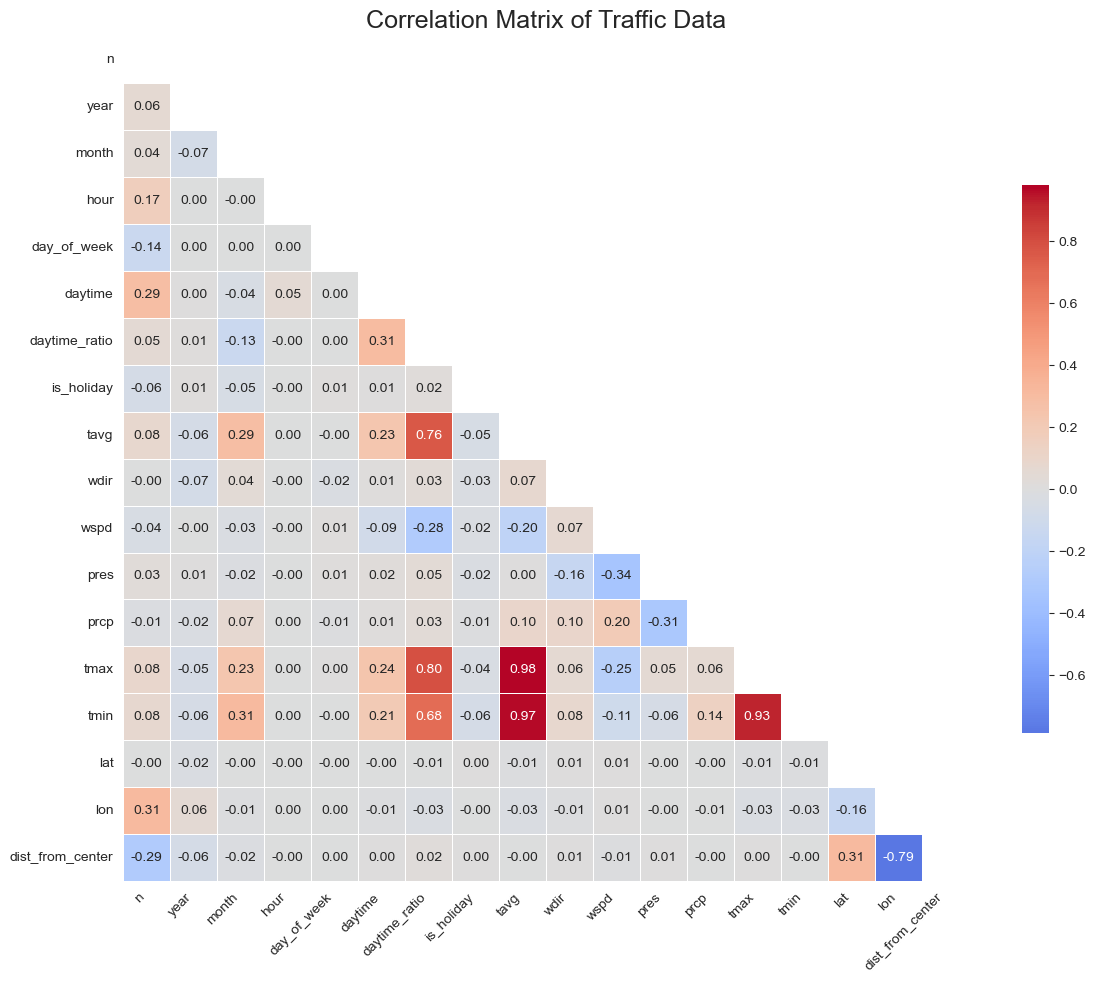

In [11]:
sns.set_style("white")

# Calculate the correlation matrix (drop non-numeric features)
cm = traffic_data.drop(["road_name", "date", "datetime"], axis=1).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(cm, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 14))

# Generate a heatmap with the mask and correct aspect ratio
sns.heatmap(cm, 
            mask=mask, 
            annot=True, 
            fmt=".2f",
            cmap="coolwarm",
            cbar_kws={'shrink': 0.4},  # Adjust color bar size
            linewidths=0.5,
            annot_kws={"size": 10},
            square=True,
            center=0,
            ax=ax)

# Set the title and adjust layout for better spacing
plt.title('Correlation Matrix of Traffic Data', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the heatmap
plt.show()

### Reduce dataset

First we look for highly correlated features in the matrix, with an absolute correlation coefficient > 0.95. Features with high (positive or negative) correlation can decrease model efficiency, so it's good practice to exclude them from the analysis. We have three highly correlated features, `tmin`, `tmax`, `tavg` - all describing temperature. It would make sense to only keep one of these for further analysis. Let's take a look which one has the strongest correlation with the target variable, and get rid of the other two:

In [12]:
cm.n[["tavg", "tmax", "tmin"]]

tavg    0.083636
tmax    0.084358
tmin    0.076576
Name: n, dtype: float64

In [13]:
# The maximum temperature has the highest correlation coefficient, we drop tmin and tavg
traffic_data.drop(["tmin", "tavg"], axis = 1, inplace = True)

### Important features

Let's take a look at the features shoving the strongest correlation with the target variable:
* `daytime` has an R of 0.29. As we can recall, `daytime` was a binary feature, with the value 0 for datapoints recorded at nighttime and 1 for measurements during the day. So the positive correlation basically indicates that there's - not suprisingly - **more bike traffic when the sun is up**.
* `dist_from_center` has an R of -0.29. This indicates that **as we get further from the city center, cycling traffic decreases**. We have to keep in mind that this variable was derived from the categorical variable `road_name`, indicating the exact location of the traffic counts, which therefore might also be an iportant factor in the analysis. `lon` (longitude, the east-west position) of the traffic count has an even higher correlation coefficient (0.31), indicating that **counting stations to the east side of the city generally have higher traffic**.
* there are two features that show a weak, but noticable correlation with `n`: the two temporal features `hour` (R = 0.17) and `day_of_week` (R = -0.14). When it comes to `hour`, the relation between the time of the day and traffic might be not be linear, ie. a multimodal distribution due to morning and evening traffic peaks might not result in a strong correlation, so it is worth looking into the exact by-hour distribution of traffic data. `day_of_week` encodes Monday as 1, Tuesday as 2, and so on, with the days of the weekend having the highest values, so a weak correlation might point to **weekends having less traffic**, wich would make sense.
* The other features do not really show any direct correlation with the target variable.

**In the following subsections, we'll explore one-by one how the features listed above influence cycling traffic.**

## 3.1. Temporal variation: hour of the day, and weekdays vs. weekends

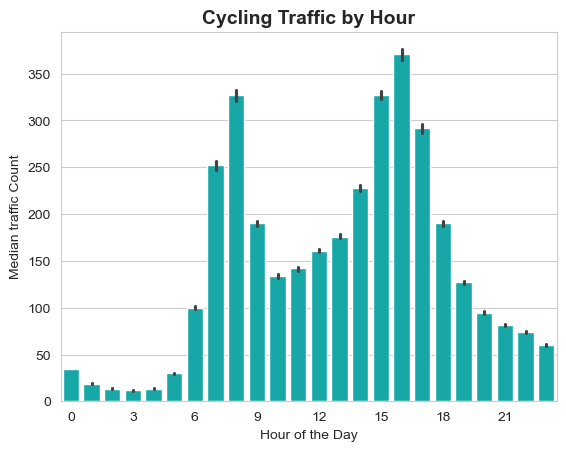

In [14]:
sns.set_style("whitegrid")

sns.barplot(data=traffic_data, x="hour", y="n", color="coolwarm"[0], estimator = "median")

# Set custom ticks every 3 hours and add the x-axis title
plt.xticks(range(0, 24, 3))
plt.xlabel("Hour of the Day")
plt.ylabel("Median traffic Count")

# Set the title with improved formatting
plt.title("Cycling Traffic by Hour", fontsize=14, weight='bold')

# Display the plot
plt.show()

From the figure above, we can see that there's a **bimodal distribution of traffic during the day, with peak hours being 8am and 4pm** - the start and and of the workday.

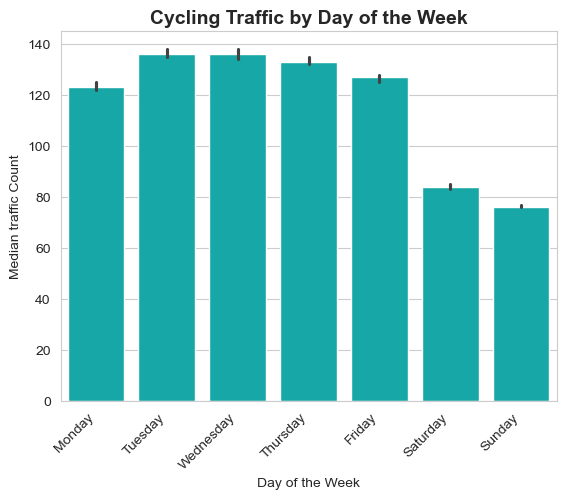

In [18]:
sns.barplot(data=traffic_data, x="day_of_week", y="n", color="coolwarm"[0], estimator = "median")

plt.xlabel("Day of the Week")
plt.ylabel("Median traffic Count")
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45, ha='right')

# Set the title with improved formatting
plt.title("Cycling Traffic by Day of the Week", fontsize=14, weight='bold')

# Display the plot
plt.show()

We can see that traffic drops a lot during weekends, with Sunday being the least busy day of the week. Overall, variations in temporal data are mainly shaped by how the work schedule of the city's population is structured, indicating that a large proportion of all cycling trips in Copenhagen are commutes to and from to work.

### 3.2. Geospatial variation: location and distance from city center

For visualising geospatial data, we use the `geopandas` library. Maps are plotted on the openly available `.geojson` of the city's districts from [opendata.dk](https://www.opendata.dk/city-of-copenhagen/bydele).

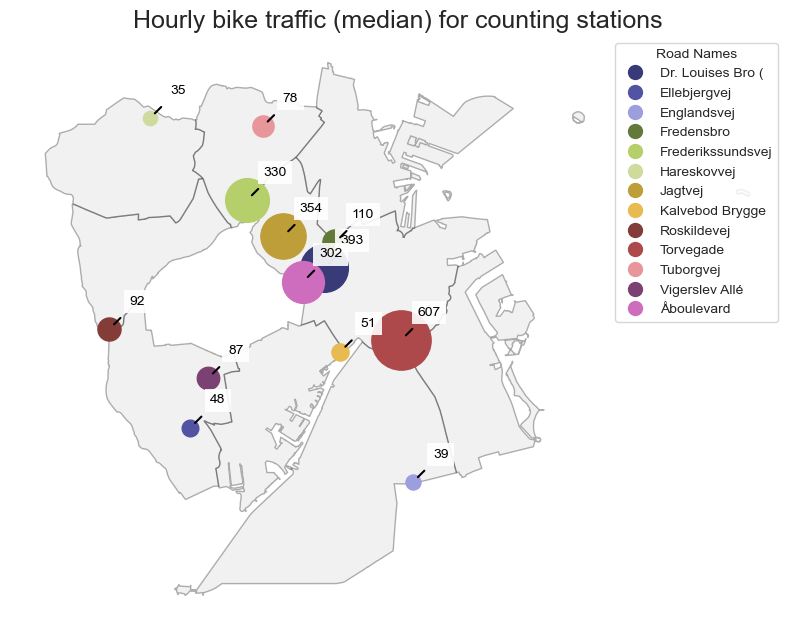

In [19]:
# Load the GeoJSON file into a GeoDataFrame
df = gpd.read_file("data/copenhagen.geojson")

# Initialize plot of the city
ax = df.plot(figsize=(10, 10), alpha=0.3, edgecolor="black", color="lightgray")

# Group data by 'road_name' and calculate the median of 'n', 'lat', and 'lon'
d = traffic_data.groupby("road_name", as_index=False)[["n", "lat", "lon"]].median()

# Convert the grouped DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(d.lon, d.lat)]
geo_d = gpd.GeoDataFrame(d, geometry=geometry)

# Ensure the GeoDataFrame has the same CRS as the map
geo_d.set_crs(epsg=4326, inplace=True)
geo_d.to_crs(crs=df.crs, inplace=True)

# Assign colors to each road_name
road_names = geo_d['road_name']
colormap = plt.get_cmap("tab20b")
colors = [colormap(i / len(road_names)) for i in range(len(road_names))]
color_dict = {name: colors[i] for i, name in enumerate(road_names)}

# Plot the points on the existing map with size varying by 'n' and color by 'road_name'
for road_name, group in geo_d.groupby('road_name'):
    group.plot(ax=ax, marker='o', color=[color_dict[road_name]], markersize=group['n'] * 3, label=road_name)  # Adjust multiplier as needed

    # Add annotations for each point
    for idx, row in group.iterrows():
        ax.annotate(
            int(row['n']),  # Annotation text (convert to int if necessary)
            xy=(row.geometry.x, row.geometry.y),  # Point location
            xytext=(20, 20),  # Offset for the annotation text
            textcoords='offset points',
            fontsize=10,  # Increase font size for readability
            color='black',  # Annotation text color
            ha='center',  # Horizontal alignment
            va='center',  # Vertical alignment
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.9),  # Background for readability
            arrowprops=dict(arrowstyle='-', color='black', lw=1.5, shrinkA=5, shrinkB=5)
        )

# Create legend with uniform size markers
import matplotlib.lines as mlines
legend_handles = [mlines.Line2D([], [], color=color_dict[name], marker='o', linestyle='', markersize=10, label=name[:17]) for name in road_names]

ax.legend(handles=legend_handles, title="Road Names")
ax.set_axis_off()

plt.title('Hourly bike traffic (median) for counting stations', fontsize=18)

# Show the plot
plt.show()


Looking at the map above, it seems like there's two distinct clusters of counting stations: high-traffic ones along a northwest-southeast diagonal (from Frederikssundvej to Torvegade), and low-traffic periferial ones in outer-Copenhagen. Let's try to classify these using K-nearest neighbour classifier.

In [20]:
from sklearn.cluster import KMeans

# Group data and average traffic count data (also spatial information)
locations = traffic_data.groupby("road_name", as_index=False)[["n", "lat", "lon", "dist_from_center"]].median()

# Extract the road names to preserve them
codes = locations.road_name

# Drop the road_name column to keep only the numeric data for clustering
locations.drop("road_name", axis=1, inplace=True)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42).fit(locations)

# Attach the cluster labels back to the road names
code_df = pd.DataFrame({"road_name": codes,
             "cluster": kmeans.labels_})

# If needed, you can merge the cluster labels back to the original traffic_data
#traffic_data = pd.merge(traffic_data, code_df, on="road_name", how="left")


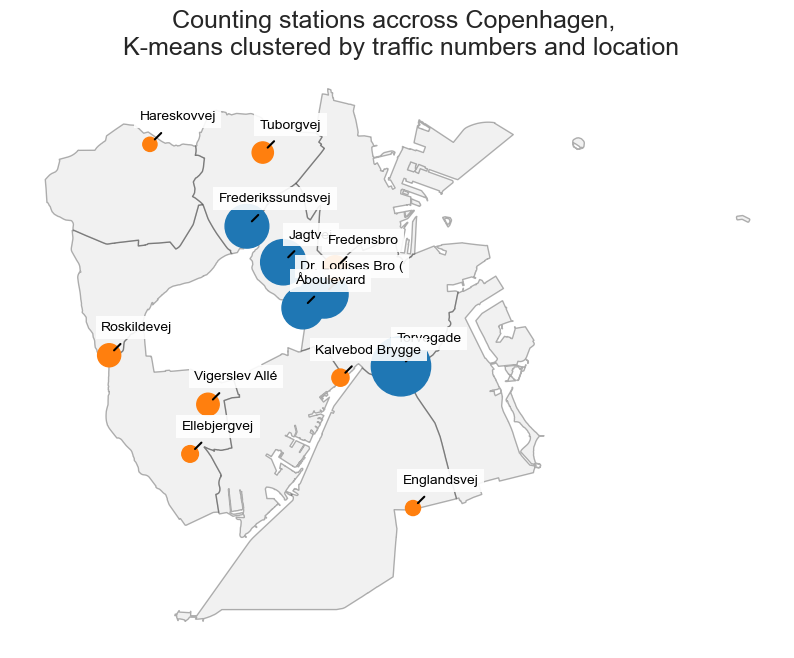

In [21]:
# Let's plot traffic data again, now with the cluster data included

# Initialize plot of the city
ax = df.plot(figsize=(10, 10), alpha=0.3, edgecolor="black", color = "lightgray")

# Group and average data, merging it with the clusters
d = traffic_data.groupby("road_name", as_index=False)[["n", "lat", "lon"]].median()
dc = pd.merge(d, code_df, on="road_name", how="left")

# Convert the grouped DataFrame to a GeoDataFrame
geo_dc = gpd.GeoDataFrame(dc, geometry=geometry)

# Ensure the GeoDataFrame has the same CRS as the map
geo_dc.set_crs(epsg=4326, inplace=True)
geo_dc.to_crs(crs=df.crs, inplace=True)


# Plot the points on the existing map with size varying by 'n' and color by 'cluster'
for road_name, group in geo_dc.groupby(['cluster']):
    group.plot(ax=ax, marker="o", markersize=group['n'] * 3, label='cluster')  # Adjust multiplier as needed
    # Add annotations for each point
    for idx, row in group.iterrows():
        ax.annotate(
            row['road_name'][:17],  # Annotation text 
            xy=(row.geometry.x, row.geometry.y),  # Point location
            xytext=(20, 20),  # Offset for the annotation text
            textcoords='offset points',
            fontsize=10,  # Increase font size for readability
            color='black',  # Annotation text color
            ha='center',  # Horizontal alignment
            va='center',  # Vertical alignment
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.9),  # Background for readability
            arrowprops=dict(arrowstyle='-', color='black', lw=1.5, shrinkA=5, shrinkB=5)
        )

ax.set_axis_off()

plt.title('Counting stations accross Copenhagen, \n K-means clustered by traffic numbers and location', fontsize=18)

# Show the plot
plt.show()

### Hourly variations of traffic during the day on different Counting stations

We have seen that location highly influences bike traffic. Let's take a look at hourly temporal patterns at these different locations.

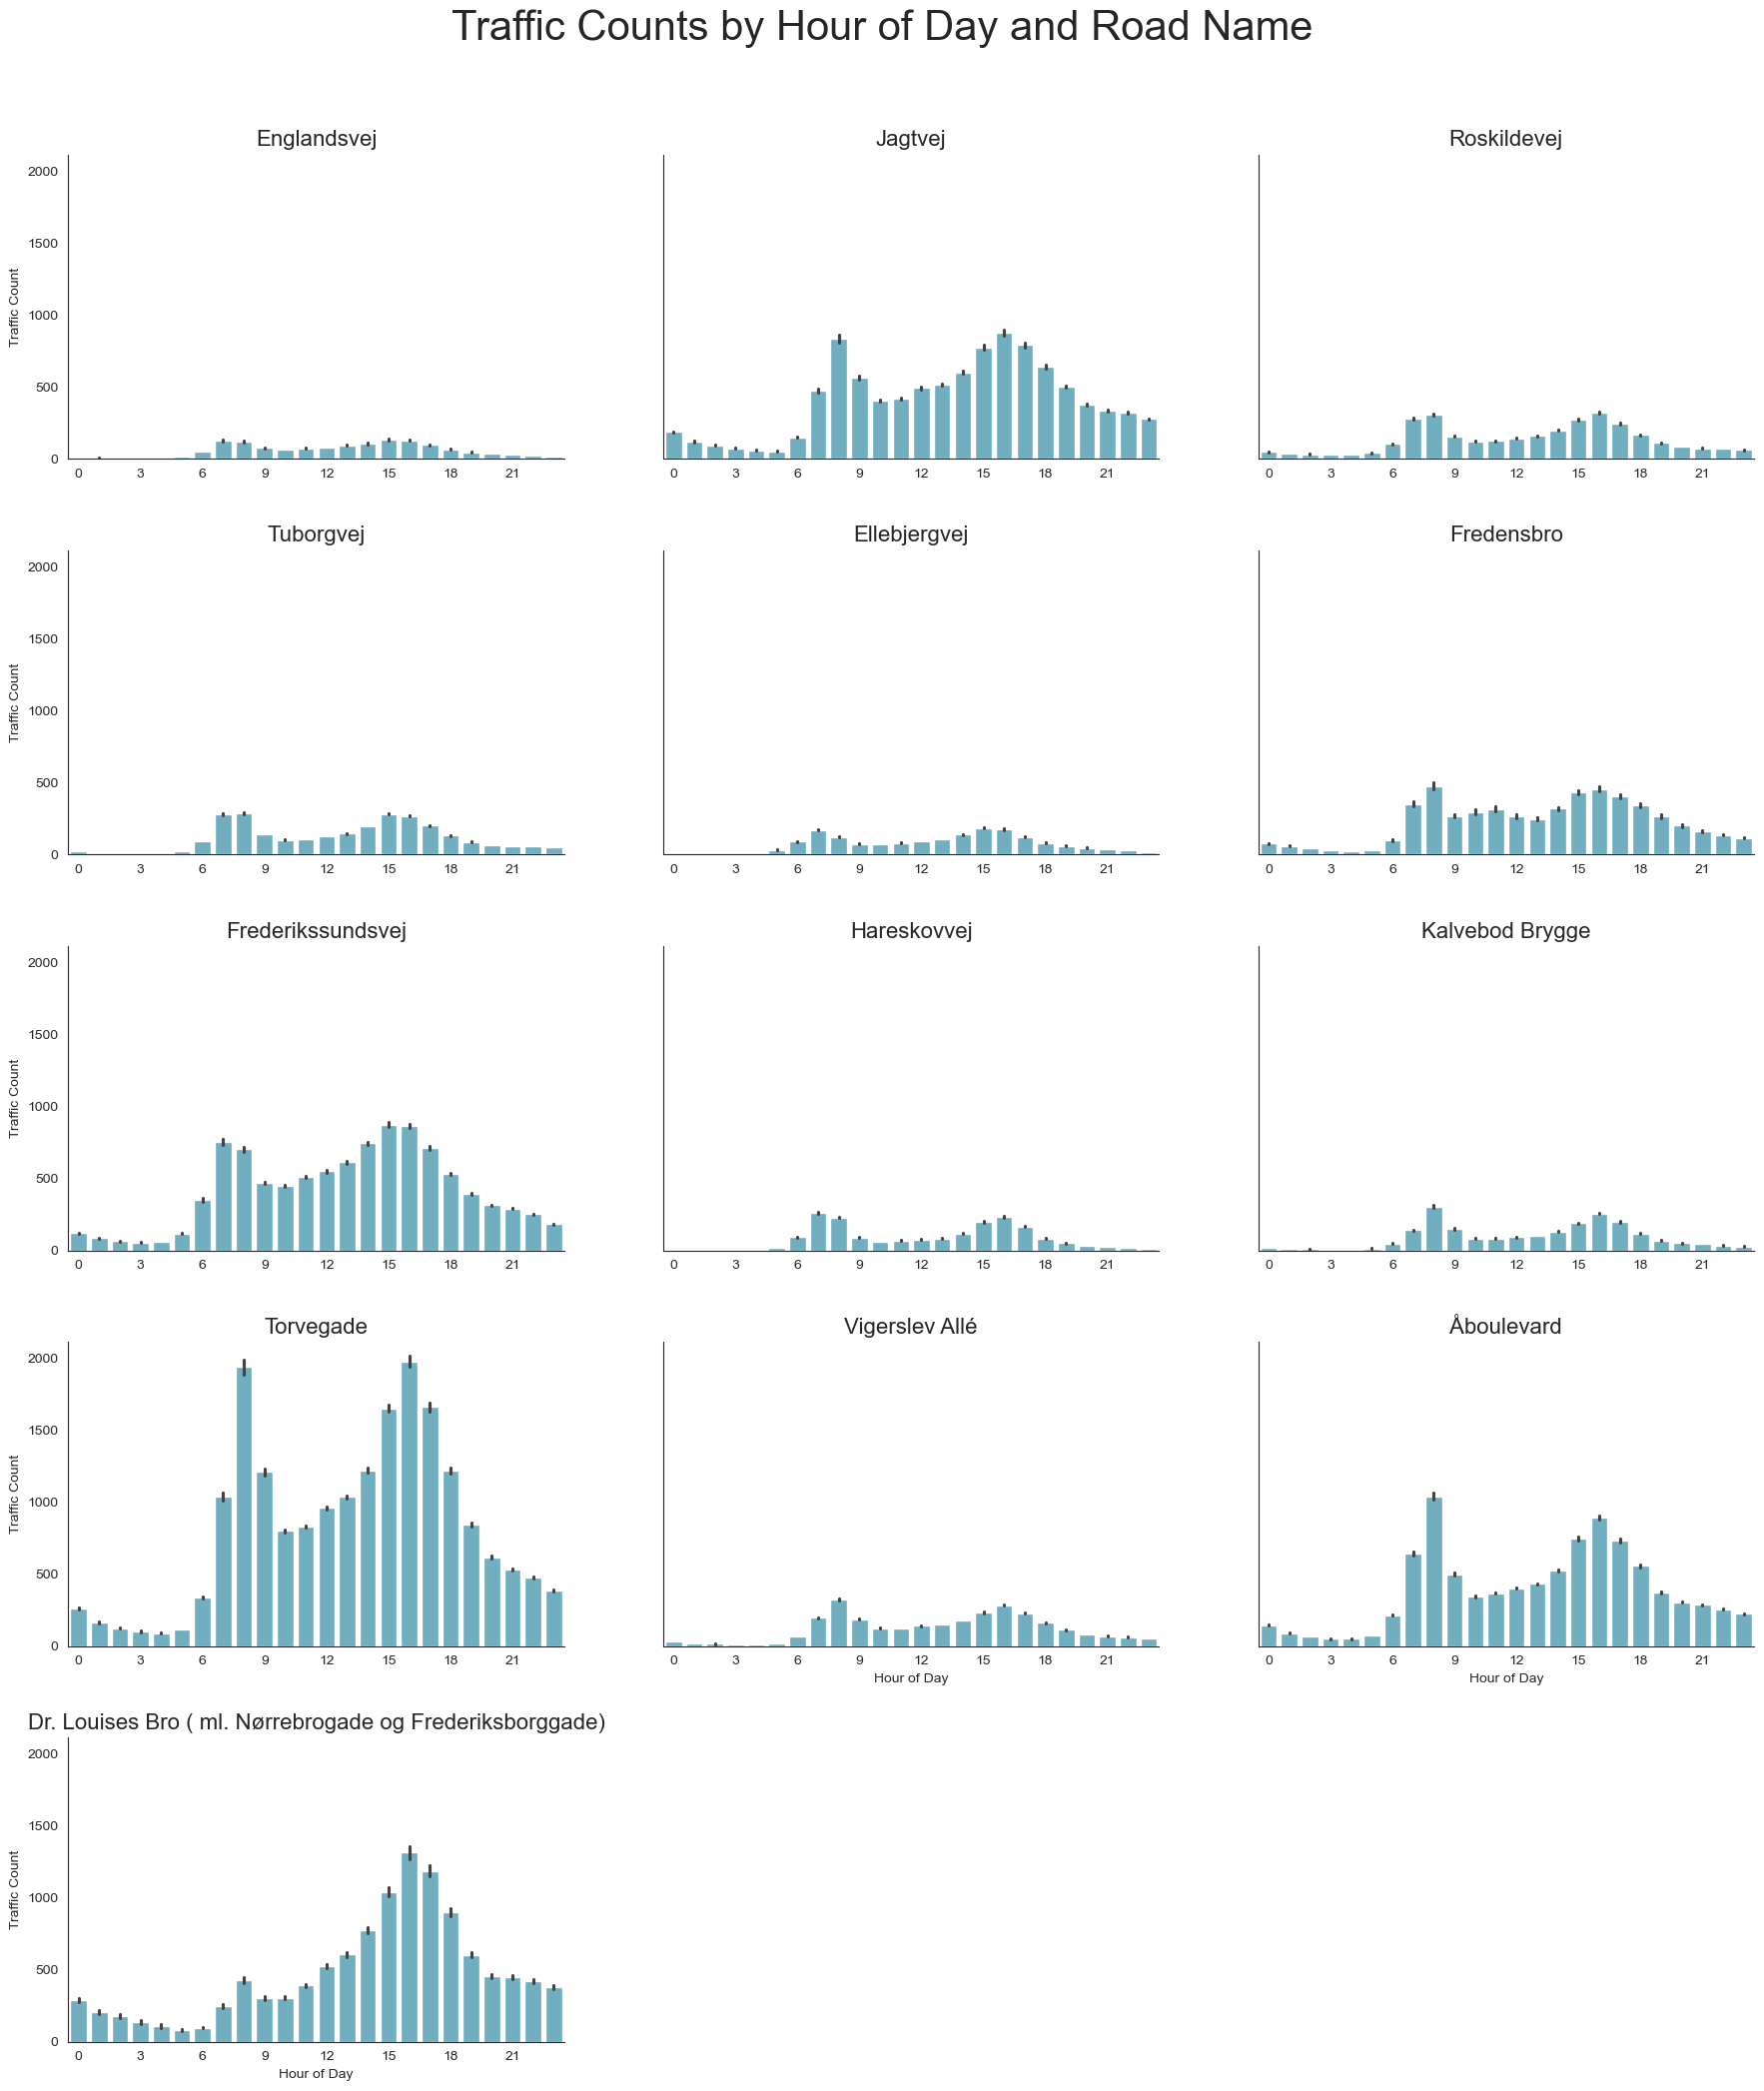

In [22]:
sns.set_style("white")
# Initialize the FacetGrid object
g = sns.FacetGrid(traffic_data, col="road_name", col_wrap=3, height=4, aspect=1.5, sharex=False)

sns.set(font_scale=1.5)

# Map the barplot onto the grid
g.map_dataframe(sns.barplot, y="n", x="hour", color="coolwarm"[0])

# Add titles and labels
g.set_axis_labels("Hour of Day", "Traffic Count")
g.set_titles(col_template="{col_name}", size=16)
g.fig.suptitle("Traffic Counts by Hour of Day and Road Name", size=30, y=1.05)

# Set custom ticks and manually add the x-axis title
for ax in g.axes.flat:
    ax.set_xticks(range(0, 24, 3))  # Label every third hour

g.fig.subplots_adjust(hspace=0.3, wspace=0.2)

# Show plot
plt.show()

Looking  This pattern seems quite uniform accross locations, except from one: for Dronning Louises Bro, although the distribution is still bimodal, the evening peak is three times the size of the morning peak. This location is a bridge on the road Nørrebrogade, the principal road of district Nørrebro, with a plethora of bars and restaurants along the way, which might explain the busier traffic during post-work hours.